# Linear Regression of Cooling Load in a Data Center
I worked at Medallion Data Center as a data center intern

# Synthetic Data Linear Regression


X2 = Surface Area

X3 = Wall Area

Y2 = Cooling Load

# Generating Synthetic Data Script

In [110]:
import numpy as np
import pandas as pd

np.random.seed(42)

n_samples = 5000

# Continuous features (similar ranges based on sample)
X1 = np.random.uniform(0.7, 1.0, size=n_samples)           # Relative Compactness
X2 = np.random.uniform(500, 650, size=n_samples)           # Surface Area
X3 = np.random.uniform(280, 320, size=n_samples)           # Wall Area
X4 = np.random.uniform(100, 150, size=n_samples)           # Roof Area
X5 = np.full(n_samples, 7.0)                               # Overall Height fixed to 7.0 (like sample)
X7 = np.zeros(n_samples)                                   # Glazing Area all zeros (like sample)

# Discrete features
X6 = np.random.choice([2,3,4,5], size=n_samples)          # Orientation
X8 = np.zeros(n_samples, dtype=int)                        # Glazing Area Distribution all zeros (like sample)

# Create a base cooling load (Y2) using a plausible linear combination + discrete effects + noise
Y2 = (
    0.085 * X2 +
    0.005 * X3 +
         # slight increase per orientation value
    np.random.normal(0, 1, size=n_samples)    # noise
)

# Heating load (Y1) can be correlated but different from cooling load, add some noise
Y1 = Y2 * 0.7 + np.random.normal(0, 2, size=n_samples)

# Build DataFrame
df = pd.DataFrame({
    'X2': np.round(X1, 2),
    'X3': np.round(X2, 2),
  # Heating Load
    'Y2': np.round(Y2, 2)   # Cooling Load
})

df.to_csv("synthetic_ENB2012_full.csv", index=False)

print("Sample rows from synthetic dataset:")
print(df.head(10))


Sample rows from synthetic dataset:
     X2      X3     Y2
0  0.81  559.05  48.06
1  0.99  571.02  49.82
2  0.92  628.18  55.32
3  0.88  551.00  48.03
4  0.75  630.45  56.39
5  0.75  513.22  43.69
6  0.72  616.52  54.93
7  0.96  627.13  55.50
8  0.88  527.27  45.80
9  0.91  564.55  48.61


In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [115]:
# --- Load data ---
df = pd.read_csv('synthetic_ENB2012_full.csv')

# --- Select features and target (excluding X6 and X8) ---
features = ['X2', 'X3']
target = 'Y2'

# Drop rows with missing values in selected columns
data = df[features + [target]].dropna()

X = data[features].values
y = data[[target]].values

In [116]:
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [117]:
# --- Normalize features ---
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Normalization affects feature values by scaling them to a common range or distribution, which changes their original scale but preserves their relative differences. Specifically:

- It rescales features so they have similar magnitudes, typically between 0 and 1 (Min-Max normalization) or to have zero mean and unit variance (Standardization).

- This helps machine learning algorithms converge faster and perform better because features contribute equally rather than being dominated by those with larger numeric ranges.

- It does not change the distribution shape but shifts and scales the data.

- After normalization, the units of measurement are lost, but the data becomes comparable across features.

**Normalization makes feature values comparable and prevents bias towards features with larger scales during model training.**


In [118]:
# --- Add bias term ---
def add_bias(X):
    m = X.shape[0]
    return np.hstack((np.ones((m, 1)), X))

X_train_bias = add_bias(X_train_norm)
X_test_bias = add_bias(X_test_norm)

# --- Initialize theta ---
theta = np.zeros((X_train_bias.shape[1], 1))

### Why does MSE penalize larger errors more than MAE?

MSE (Mean Squared Error) penalizes larger errors more than MAE (Mean Absolute Error) because it squares the error values before averaging them. Here's why that matters:
MSE calculation: Each error term is squared, so larger errors become disproportionately bigger (e.g., an error of 10 becomes 100 after squaring).

MAE calculation: It takes the absolute value of errors, treating all errors linearly regardless of size.
This means MSE is more sensitive to large errors (outliers), making the model focus more on minimizing big mistakes. MAE treats all errors proportionally, so it's more robust to outliers but less sensitive to large deviations.

**MSE amplifies large errors through squaring, while MAE treats errors equally on a linear scale.**


In [ ]:

# --- Define cost function (MSE) ---
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    cost = (1/(2*m)) * np.sum(errors ** 2)
    return cost

# --- Adam optimizer ---
def gradient_descent_adam(X, y, theta, alpha, num_iters, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = len(y)
    costs = []

    m_t = np.zeros_like(theta)
    v_t = np.zeros_like(theta)

    for t in range(1, num_iters + 1):
        predictions = X.dot(theta)
        errors = predictions - y
        gradient = (1/m) * X.T.dot(errors)

        m_t = beta1 * m_t + (1 - beta1) * gradient
        v_t = beta2 * v_t + (1 - beta2) * (gradient ** 2)

        m_hat = m_t / (1 - beta1 ** t)
        v_hat = v_t / (1 - beta2 ** t)

        theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        cost = compute_cost(X, y, theta)
        costs.append(cost)

        if np.isnan(cost) or cost > 1e10:
            print(f"Stopped at iteration {t}: Cost diverged")
            break


    return theta, costs

In [119]:
# --- Hyperparameters ---
alpha = 0.09  # learning rate
num_iters = 9000


# How does the learning rate affect convergence?
The learning rate controls how big each step is when updating model parameters during training (like in gradient descent). 
- If the learning rate is too **small**:

         The model takes very tiny steps. Training converges very slowly, and it might take a long time to reach the best solution. Sometimes it can get stuck in local minima or take a lot of iterations.

- If the learning rate is too **large**:

        The model takes big steps. It might overshoot the optimal solution and fail to converge. The cost function can even diverge, causing training to become unstable or oscillate wildly.

- A good learning rate:

        Balances speed and stability. Allows the model to converge quickly to the minimum of the cost function without overshooting.So, the learning rate is a key hyperparameter that affects how fast and how well your model learns!


Final theta:
[[ 5.02744050e+01]
 [-1.61987618e-02]
 [ 3.68968191e+00]]
Final training cost: 0.5048840691109094
Train MSE: 1.0097681382218189
Train MAE: 0.8019958303978756
Test MSE: 0.9688822606448011
Test MAE: 0.7868628487329726


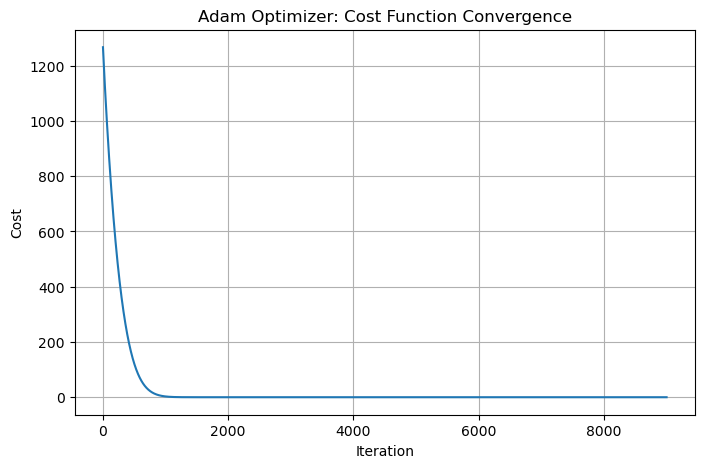

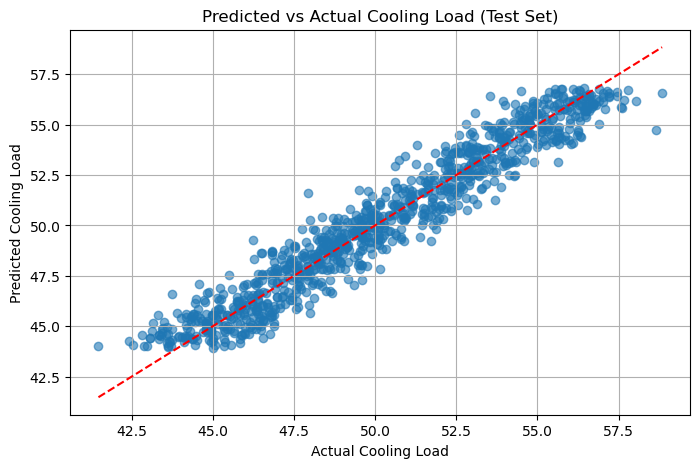

In [120]:




# --- Run Adam optimizer ---
theta_final, cost_history = gradient_descent_adam(X_train_bias, y_train, theta, alpha, num_iters)

print("\nFinal theta:")
print(theta_final)

print(f"Final training cost: {cost_history[-1]}")

# --- Predictions ---
y_train_pred = X_train_bias.dot(theta_final)
y_test_pred = X_test_bias.dot(theta_final)

# --- Metrics ---
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# --- Plot cost convergence ---
plt.figure(figsize=(8,5))
plt.plot(cost_history)
plt.title("Adam Optimizer: Cost Function Convergence")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# --- Plot predicted vs actual on test set ---
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45 degree line
plt.xlabel("Actual Cooling Load")
plt.ylabel("Predicted Cooling Load")
plt.title("Predicted vs Actual Cooling Load (Test Set)")
plt.grid(True)
plt.show()


# Test With Real World Data

**Using Dataset**:
A. Tsanas and A. Xifara. "Energy Efficiency," UCI Machine Learning Repository, 2012. [Online]. Available: https://doi.org/10.24432/C51307.

X2 = Surface Area

X3 = Wall Area

Y2 = Cooling Load

Train MSE: 19.87790215393396
Train MAE: 3.151211507514247
Test MSE: 21.102683161528937
Test MAE: 3.3264993343619635


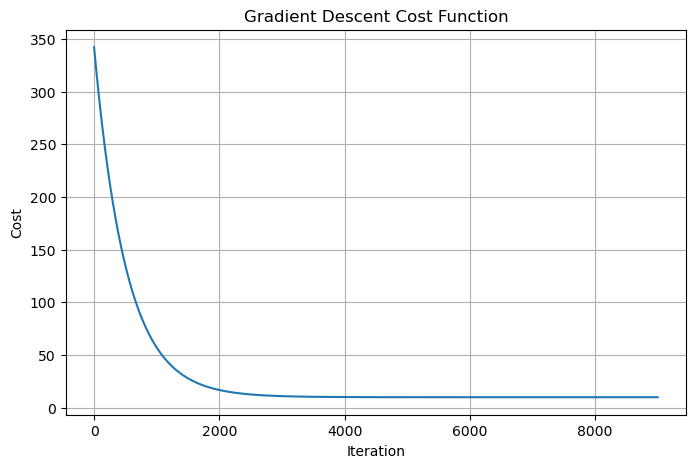

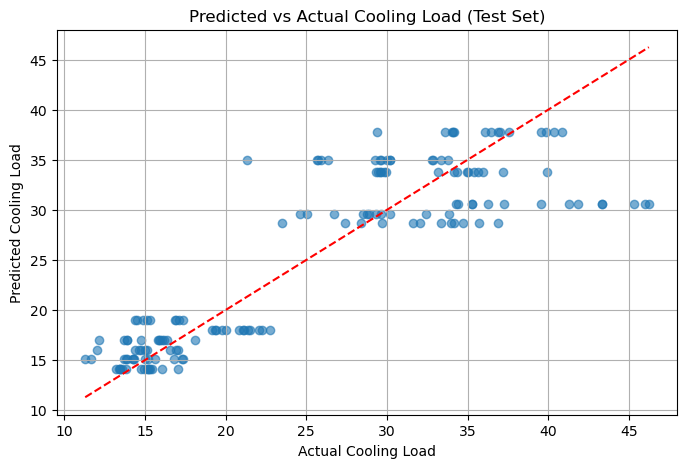

In [90]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('ENB2012_data.csv')

# Select features and target (exclude X6 and X8)
features = ['X2', 'X3']
target = 'Y2'

X = df[features].values
y = df[[target]].values

# Check and drop NaNs if any
data = pd.concat([df[features], df[[target]]], axis=1).dropna()
X = data[features].values
y = data[[target]].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add bias term
def add_bias(X):
    m = X.shape[0]
    return np.hstack((np.ones((m, 1)), X))

X_train_bias = add_bias(X_train_norm)
X_test_bias = add_bias(X_test_norm)

# Initialize theta
theta = np.zeros((X_train_bias.shape[1], 1))

# Cost function
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    errors = predictions - y
    cost = (1/(2*m)) * np.sum(errors ** 2)
    return cost

# Gradient descent
def gradient_descent(X, y, theta, alpha, num_iters):
    m = len(y)
    costs = []
    for i in range(num_iters):
        predictions = X.dot(theta)
        errors = predictions - y
        gradient = (1/m) * X.T.dot(errors)
        theta = theta - alpha * gradient

        cost = compute_cost(X, y, theta)
        costs.append(cost)

        if np.isnan(cost) or cost > 1e10:
            print(f"Stopped at iteration {i}: Cost diverged")
            break
       

    return theta, costs

# Hyperparameters
alpha = 0.001
num_iters = 9000

# Train model
theta_final, cost_history = gradient_descent(X_train_bias, y_train, theta, alpha, num_iters)

# Predictions
y_train_pred = X_train_bias.dot(theta_final)
y_test_pred = X_test_bias.dot(theta_final)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Plot cost convergence
plt.figure(figsize=(8,5))
plt.plot(cost_history)
plt.title("Gradient Descent Cost Function")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Plot predicted vs actual (test set)
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Cooling Load")
plt.ylabel("Predicted Cooling Load")
plt.title("Predicted vs Actual Cooling Load (Test Set)")
plt.grid(True)
plt.show()


# Why might the model perform differently on real vs. synthetic data
Synthetic data is great for initial testing or understanding algorithms, but real data challenges the model with real-world imperfections and complexity, often making performance worse or more variable.

Data Complexity:
Real data usually has more complexity, noise, missing values, outliers, and irregular patterns. Synthetic data is often cleaner and follows simpler, idealized rules.

Feature Relationships:
In synthetic data, relationships between features and targets are typically well-defined and linear or follow the model's assumptions. Real data relationships may be nonlinear, hidden, or influenced by unknown factors.

Distribution Differences:
Synthetic data is generated from specific distributions or formulas, so it might not capture the true variability or rare cases found in real data.

Measurement Errors:
Real-world data can have inaccuracies from data collection, sensor errors, or human mistakes, which synthetic data doesn’t usually have.

Overfitting Synthetic Patterns:
Models might overfit to the perfect patterns in synthetic data but struggle to generalize to the messier, more complex real data.

In short:


## How does the choice of cost function (MSE vs. MAE) affect optimisation?

a. MSE penalises large errors more (because it squares them), making optimisation smoother but sensitive to outliers.

b. MAE treats all errors equally, is more robust to outliers, but harder to optimise with gradient descent.

What challenges arise when scaling to multiple features?
a. Different scales need normalisation.

b. Correlated features can mess up estimates.

c. More features can cause overfitting and increase computation.

# How does gradient descent compare to scikit-learn's built-in linear regression?

 Gradient descent is iterative, needs tuning, slower but works on big data and complex models.

b. scikit-learn’s LinearRegression uses a direct formula, is faster, no tuning needed, but only for simple linear models.